# Set Parameter
- Attention = True
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 128
- Learning rate = 0.001
- Hidden unit = 200
- Epochs = 100
- N = 50
- Data Length = 100K
- Data = [single_Ctype4_error_rate_1]
- Deduplication
- Random split

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys
import json
import numpy as np

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from models.trainer import Trainer
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from dataset import fields

import matplotlib.pyplot as plt

# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentence_accuracy = []
f1_score = []
best_f1_score = []
rnn = "lstm"
data_name = "copy"
dir_name = "separator_Ctype4_30"
pretrained_dir_name = None
iterator = list(range(1,11,1))
epochs = 200

train_path = "data/"+data_name+"_rand/correction_"+dir_name+"/data_train.txt"
dev_path = "data/"+data_name+"_rand/correction_"+dir_name+"/data_test.txt"
config_path = "models/config.json"

# Prepare dataset

In [ ]:
for i in iterator:
        print("rnn : %s" % rnn)
        max_len = 65
        src = fields.SourceField()
        srcp = fields.SourceField()
        tgt = fields.TargetField()
        tgtp = fields.TargetField()
        def len_filter(example):
            return len(example.src) <= max_len and len(example.tgt) <= max_len
        train = torchtext.data.TabularDataset(
            path=train_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        dev = torchtext.data.TabularDataset(
            path=dev_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        src.build_vocab(train)
        tgt.build_vocab(train)
        input_vocab = src.vocab
        output_vocab = tgt.vocab

        print("src vocab size = %d" % (len(src.vocab)))
        print("tat vacab size = %d" % (len(tgt.vocab)))

        weight = torch.ones(len(tgt.vocab))
        pad = tgt.vocab.stoi[tgt.pad_token]
        loss = Perplexity(weight, pad)
        if torch.cuda.is_available():
            loss.cuda()
        '''
        {
            "max_len": 104,
            "embedding_size": 5,
            "hidden_size": 200,
            "input_dropout_p": 0,
            "dropout_p": 0,
            "n_layers": 1,
            "bidirectional": false,
            "rnn_cell": "lstm",
            "variable_lengths": false,
            "embedding": null,
            "update_embedding": true,
            "get_context_vector": false,
            "use_attention": true,
            "attn_layers": 1,
            "hard_attn": false,
            "position_embedding": false,
            "pos_add": "add"
        }

        '''

        optimizer = "Adam"
        seq2seq = None
        config_json = open(config_path).read()
        config = json.loads(config_json)
        config["max_len"] = max_len
        config["hidden_size"] = 100
        config["rnn_cell"] = rnn
        config["embedding_size"] = 20
        config["use_attention"] = False
        config["position_embedding"] = "length"
        config["use_memory"] = "stack"
        #config["pos_add"] = "cat"

        print("Train_path : %s" % train_path)
        print("Dev_path = %s" % dev_path)
        print(json.dumps(config, indent=4))

        save_path = (data_name + "_rand_" + dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + ("_pretrained" if pretrained_dir_name is not None else ""))
        print("Save_path : %s" % save_path)
        
        if pretrained_dir_name is not None:
            pretrained_path = ("pretrained_weights/"+ data_name + "_rand_" + pretrained_dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + "_"+rnn+"_"+str(i))
            pretrained_pos_weight = np.load(pretrained_path+"/decoder_pos_weight.npy")
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id,
                              pretrained_pos_weight)
        else :
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
        
        if torch.cuda.is_available():
            seq2seq.cuda()

        for param in seq2seq.parameters():
            param.data.uniform_(-0.08, 0.08)

        # train
        t = Trainer(loss=loss, batch_size=128,
                    learning_rate=0.002,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=config["hidden_size"],
                    path=save_path,
                    file_name=config["rnn_cell"] + "_" + str(i))

        seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                                 num_epochs=epochs, dev_data=dev,
                                                                                 optimizer=optimizer,
                                                                                 teacher_forcing_ratio=0.5)

        character_accuracy.append(character_accuracy_list)
        sentence_accuracy.append(sentence_accuracy_list)
        f1_score.append(f1_score_list)
        best_f1_score.append(max(f1_score_list))

rnn : lstm
src vocab size = 7
tat vacab size = 10


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2020-03-15 03:16:25,569 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
), Scheduler: None


Train_path : data/copy_rand/correction_separator_Ctype4_30/data_train.txt
Dev_path = data/copy_rand/correction_separator_Ctype4_30/data_test.txt
{
    "max_len": 65,
    "embedding_size": 20,
    "hidden_size": 100,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "position_embedding": "length",
    "pos_add": "add",
    "use_memory": "queue",
    "memory_dim": 5
}
Save_path : copy_rand_separator_Ctype4_30_att_with_pos_length_use_queue_emb20_hidden100


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2020-03-15 03:18:04,750 INFO   Finished epoch 1: Train loss: 2.4463, Dev loss: 2.0232, Accuracy(character): 0.7871, Accuracy(sentence): 0.0000, F1 Score: 0.0000
2020-03-15 03:19:35,074 INFO   Finished epoch 2: Train loss: 1.9591, Dev loss: 1.9092, Accuracy(character): 0.7865, Accuracy(sentence): 0.0000, F1 Score: 0.0000
2020-03-15 03:21:06,197 INFO   Finished epoch 3: Train loss: 1.9405, Dev loss: 1.8543, Accuracy(character): 0.7952, Accuracy(sentence): 0.0265, F1 Score: 0.1205
2020-03-15 03:22:38,531 INFO   Finished epoch 4: Train loss: 1.8762, Dev loss: 1.9505, Accuracy(character): 0.7849, Accuracy(sentence): 0.0195, F1 Score: 0.0815
2020-03-15 03:24:07,753 INFO   Finished epoch 5: Train loss: 1.8919, Dev loss: 1.8272, Accuracy(character): 0.8110, Accur

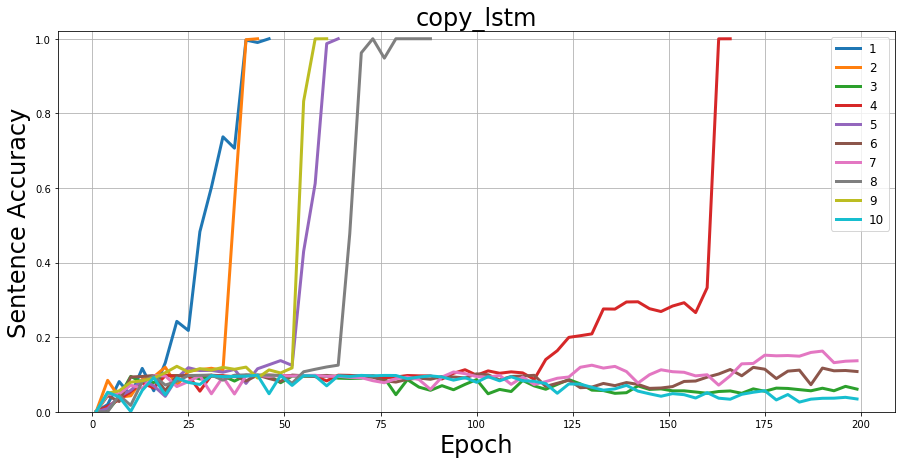

In [11]:
plt.figure(figsize=(15,7))
for j in range(len(sentence_accuracy)):
    plt.plot(list(range(1, len(sentence_accuracy[j])+1, 1))[::3], sentence_accuracy[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

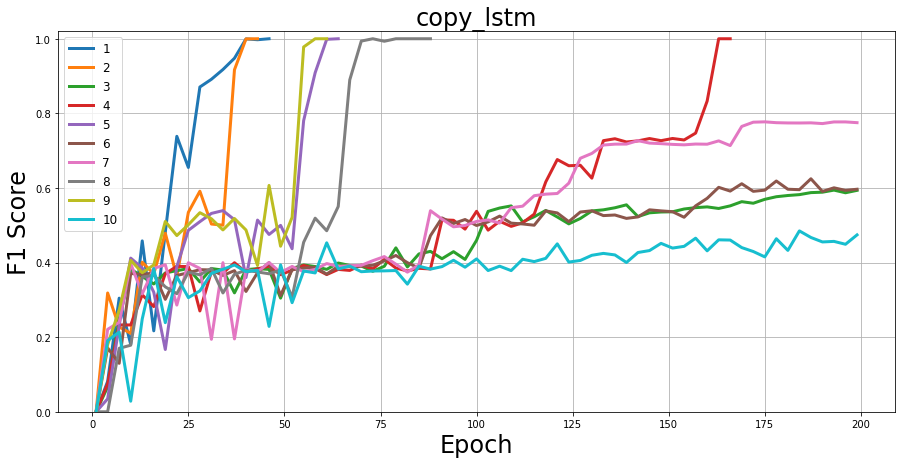

In [12]:
plt.figure(figsize=(15,7))
for j in range(len(f1_score)):
    plt.plot(list(range(1, len(f1_score[j])+1, 1))[::3], f1_score[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

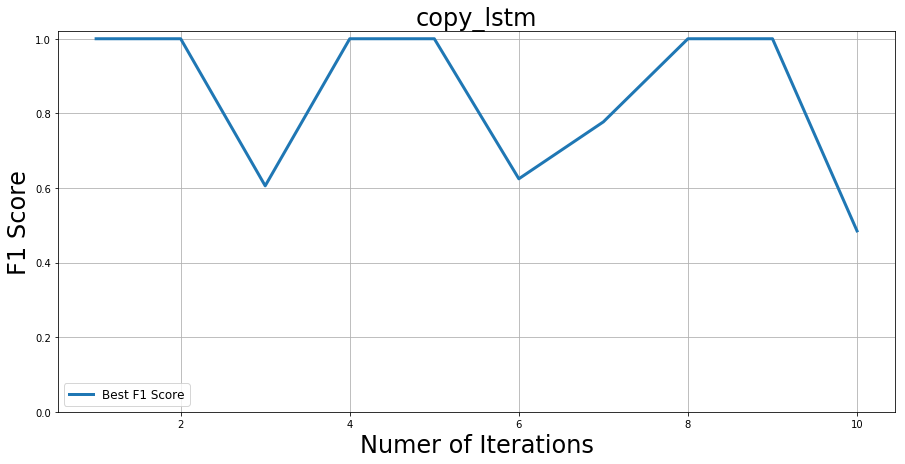

In [13]:
plt.figure(figsize=(15,7))
plt.plot(list(range(1, len(best_f1_score)+1)), best_f1_score, '-', LineWidth=3, label="Best F1 Score")

plt.legend(loc="best", fontsize=12)
plt.xlabel('Numer of Iterations', fontsize=24)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

In [14]:
print(f1_score)

[[0, 0, 0.12049620894729311, 0.08150268047885849, 0.25316598399158247, 0.180334907685702, 0.3046076800760331, 0.2513423676809, 0.12928265524625268, 0.18062061415316139, 0.3648468708388815, 0.25864525770687796, 0.45812413840053096, 0.4316013614338648, 0.4776375567895002, 0.21699560638817209, 0.4779729081754975, 0.19504937958976956, 0.48126355875329707, 0.62699203187251, 0.5098481869950664, 0.7384221812572891, 0.7825144603010876, 0.7140490351494059, 0.6549440901386467, 0.8472116307101917, 0.8132756511099458, 0.8706125258086717, 0.8862716935966487, 0.9260467268100856, 0.8913408167171439, 0.9172827935714534, 0.9470547377383433, 0.9175127045916022, 0.9249229951027101, 0.9527881742761631, 0.9477410947002607, 0.9979089557078801, 0.997704393007917, 0.999597675458203, 0.99922904166527, 0.9997988287361974, 0.9973650127283283, 0.9992183487058087, 1.0, 1.0, 1.0, 1.0], [0, 0, 0, 0.3185009950809208, 0.20775103894848748, 0.28716980566668165, 0.227254642965132, 0.30367867210617544, 0.3631964582940096,

In [15]:
print(best_f1_score)

[1.0, 1.0, 0.6057109557109558, 0.9999888246929584, 1.0, 0.6245997409009802, 0.7772374246933295, 1.0, 1.0, 0.48493140272868923]


In [16]:
print(sum(best_f1_score, 0.0)/len(best_f1_score))

0.8492468348726915
